In [23]:
import xarray as xr
import geopandas as gpd
import rioxarray # pip install rioxarray

In [24]:
# Abri o arquivo NetCDF.
ds = xr.open_dataset('chuva.nc')


In [25]:
# Tem que remover a variável "time_bnds" do Data variables. Explicação, logo abaixo.
ds

<xarray.Dataset> Size: 17MB
Dimensions:    (time: 9, bnds: 2, lon: 530, lat: 450)
Coordinates:
  * time       (time) datetime64[ns] 72B 2024-04-15T12:00:00 ... 2024-12-05
  * lon        (lon) float64 4kB -84.95 -84.85 -84.75 ... -32.25 -32.15 -32.05
  * lat        (lat) float64 4kB -34.95 -34.85 -34.75 -34.65 ... 9.75 9.85 9.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 144B ...
    crs        |S1 1B ...
    prec       (time, lat, lon) float64 17MB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Fri Oct 25 13:20:05 2024: GDAL CreateCopy( /home/ubuntu/met...
    frequency:    mon
    CDO:          Climate Data Operators version 2.1.0 (https://mpimet.mpg.de...

In [26]:
# Remove a variável 'time_bnds'. Essa variável não é necessária para a 
# análise porque não tem as dimensões lat/latitude e lon/longitude e ela 
# gera erro na hora do recorte da variável.
# Caso seu arquivo não tenha essa variável, você pode ignorar essa 
# parte (comentar essa linha).
ds = ds.drop_vars(['time_bnds'])

# Define o CRS (por exemplo, EPSG:4326 para WGS84).
ds = ds.rio.write_crs("EPSG:4326", inplace=True)

# Renomeia as dimensões lon/longitude e lat/latitude para x e y, respectivamente.
# Tem que fazer isso, não aceita o nome lon/longitude e lat/latitude.
ds = ds.rename({'lon': 'x', 'lat': 'y'})

# Abre o arquivo shapefile das bacias hidrográficas.
shapefile = './bacias/Contorno_Bacias_rev2.shp'
bacias = gpd.read_file(shapefile)

# Filtra a bacia de interesse. Neste caso, Grande.
# "Nome_Bacia" = É a coluna do shapefile que contém o nome da bacia.
# "bacias" é o shapefile que contém todas as bacias hidrográficas.
filtro = bacias['Nome_Bacia'] == 'Grande'
# Aplica o filtro para a bacia de interesse.
gdf = bacias[filtro]

<AxesSubplot:>

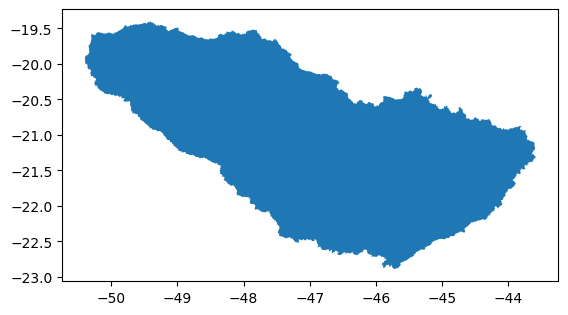

In [27]:
# Plot da bacia de interesse.
gdf.plot()

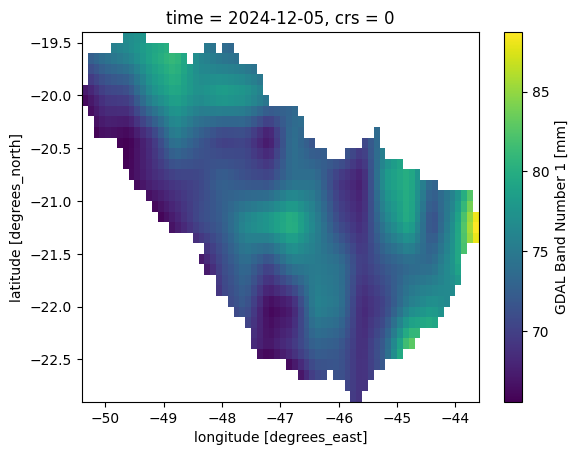

In [28]:
# Quando o recorte é feito, a variável "prec" é recortada para a bacia desejada.
# O recorte é feito com a geometria do shapefile.
# O recorte é feito com a projeção correta (CRS).
# O drop=True remove as coordenadas que não estão dentro da geometria.
# O resultado é um novo DataArray que contém apenas os dados da bacia desejada.
recorte = ds.rio.clip(gdf.geometry, bacias.crs, drop=True)

# Plot básico do ultimo tempo (-1).
recorte['prec'][-1,:,:].plot()